In [1]:
import sys
import os
import random
import math
import time
import torch; torch.utils.backcompat.broadcast_warning.enabled = True
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn; cudnn.benchmark = True
import numpy as np
import models
from EEG_Image_Dataset import *
import importlib
import argparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

In [3]:
parser = argparse.ArgumentParser(description="Template")
### BLOCK DESIGN ###
#Data
#parser.add_argument('-ed', '--eeg-dataset', default=r"data\block\eeg_55_95_std.pth", help="EEG dataset path") #55-95Hz
parser.add_argument('-ed', '--eeg-dataset', default=r"/users/sbr/data/eeg_55_95_std.pth", help="EEG dataset path") #5-95Hz
#parser.add_argument('-ed', '--eeg-dataset', default=r"data\block\eeg_14_70_std.pth", help="EEG dataset path") #14-70Hz
#Splits
parser.add_argument('-sp', '--splits-path', default=r"/users/sbr/data/block_splits_by_image_all.pth", help="splits path") #All subjects
#parser.add_argument('-sp', '--splits-path', default=r"data\block\block_splits_by_image_single.pth", help="splits path") #Single subject
### BLOCK DESIGN ###

parser.add_argument('-sn', '--split-num', default=0, type=int, help="split number") #leave this always to zero.

#Subject selecting
parser.add_argument('-sub','--subject', default=0   , type=int, help="choose a subject from 1 to 6, default is 0 (all subjects)")

#Time options: select from 20 to 460 samples from EEG data
parser.add_argument('-tl', '--time_low', default=20, type=float, help="lowest time value")
parser.add_argument('-th', '--time_high', default=460,  type=float, help="highest time value")

# Model type/options
parser.add_argument('-mt','--model_type', default='EEGChannelNet', help='specify which generator should be used: lstm|EEGChannelNet')
# It is possible to test out multiple deep classifiers:
# - lstm is the model described in the paper "Deep Learning Human Mind for Automated Visual Classification”, in CVPR 2017
# - model10 is the model described in the paper "Decoding brain representations by multimodal learning of neural activity and visual features", TPAMI 2020
parser.add_argument('-mp','--model_params', default='', nargs='*', help='list of key=value pairs of model options')
parser.add_argument('--pretrained_net', default='', help="path to pre-trained net (to continue training)")

# Training options
parser.add_argument("-b", "--batch_size", default=32, type=int, help="batch size")
parser.add_argument('-o', '--optim', default="Adam", help="optimizer")
parser.add_argument('-lr', '--learning-rate', default=0.001, type=float, help="learning rate")
parser.add_argument('-lrdb', '--learning-rate-decay-by', default=0.5, type=float, help="learning rate decay factor")
parser.add_argument('-lrde', '--learning-rate-decay-every', default=10, type=int, help="learning rate decay period")
parser.add_argument('-dw', '--data-workers', default=4, type=int, help="data loading workers")
parser.add_argument('-e', '--epochs', default=100, type=int, help="training epochs")

# Save options
parser.add_argument('-sc', '--saveCheck', default=20, type=int, help="learning rate")

# Backend options
parser.add_argument('--no-cuda', default=False, help="disable CUDA", action="store_true")

# Parse arguments
opt, _ = parser.parse_known_args()
print(opt)

Namespace(batch_size=32, data_workers=4, eeg_dataset='/users/sbr/data/eeg_55_95_std.pth', epochs=100, learning_rate=0.001, learning_rate_decay_by=0.5, learning_rate_decay_every=10, model_params='', model_type='EEGChannelNet', no_cuda=False, optim='Adam', pretrained_net='', saveCheck=20, split_num=0, splits_path='/users/sbr/data/block_splits_by_image_all.pth', subject=0, time_high=460, time_low=20)


In [3]:
# Dataset class
class EEGDataset:
    
    # Constructor
    def __init__(self, eeg_signals_path):
        # Load EEG signals
        loaded = torch.load(eeg_signals_path)
        if opt.subject!=0:
            self.data = [loaded['dataset'][i] for i in range(len(loaded['dataset']) ) if loaded['dataset'][i]['subject']==opt.subject]
        else:
            self.data=loaded['dataset']        
        self.labels = loaded["labels"]
        self.images = loaded["images"]
        
        # Compute size
        self.size = len(self.data)

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Process EEG
        eeg = self.data[i]["eeg"].float().t()
        eeg = eeg[opt.time_low:opt.time_high,:]

        if opt.model_type == "EEGChannelNet":
            eeg = eeg.t()
            eeg = eeg.view(1,128,opt.time_high-opt.time_low)
        # Get label
        label = self.data[i]["label"]
        # Return
        return eeg, label

# Splitter class
class Splitter:

    def __init__(self, dataset, split_path, split_num=0, split_name="train"):
        # Set EEG dataset
        self.dataset = dataset
        # Load split
        loaded = torch.load(split_path)
        self.split_idx = loaded["splits"][split_num][split_name]
        # Filter data
        self.split_idx = [i for i in self.split_idx if 450 <= self.dataset.data[i]["eeg"].size(1) <= 600]
        # Compute size
        self.size = len(self.split_idx)

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Get sample from dataset
        eeg, label = self.dataset[self.split_idx[i]]
        # Return
        return eeg, label


In [6]:
dataset = EEGDataset(opt.eeg_dataset)
loaders = {split: DataLoader(Splitter(dataset, split_path = opt.splits_path, split_num = opt.split_num, split_name = split), batch_size = opt.batch_size, drop_last = True, shuffle = True) for split in ["train", "val", "test"]}

# Load model
model_options = {key: int(value) if value.isdigit() else (float(value) if value[0].isdigit() else value) for (key, value) in [x.split("=") for x in opt.model_params]}
# Create discriminator model/optimizer
module = importlib.import_module("models." + opt.model_type)
model = module.Model(**model_options)
optimizer = getattr(torch.optim, opt.optim)(model.parameters(), lr = opt.learning_rate)
    
# Setup CUDA
if not opt.no_cuda:
    model.cuda()
    print("Copied to CUDA")

if opt.pretrained_net != '':
        model = torch.load(opt.pretrained_net)
        print(model)

#initialize training,validation, test losses and accuracy list
losses_per_epoch={"train":[], "val":[],"test":[]}
accuracies_per_epoch={"train":[],"val":[],"test":[]}

best_accuracy = 0
best_accuracy_val = 0
best_epoch = 0
# Start training

predicted_labels = [] 
correct_labels = []

for epoch in range(1, opt.epochs+1):
    start = time.time()
    # Initialize loss/accuracy variables
    losses = {"train": 0, "val": 0, "test": 0}
    accuracies = {"train": 0, "val": 0, "test": 0}
    counts = {"train": 0, "val": 0, "test": 0}
    # Adjust learning rate for SGD
    if opt.optim == "SGD":
        lr = opt.learning_rate * (opt.learning_rate_decay_by ** (epoch // opt.learning_rate_decay_every))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    # Process each split
    for split in ("train", "val", "test"):
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all split batches
        for i, (input, target) in enumerate(loaders[split]):
            # Check CUDA
            if not opt.no_cuda:
                input = input.to("cuda") 
                target = target.to("cuda") 
            # Forward
            _, output = model(input)

            # Compute loss
            loss = F.cross_entropy(output, target)
            losses[split] += loss.item()
            # Compute accuracy
            _,pred = output.data.max(1)
            correct = pred.eq(target.data).sum().item()
            accuracy = correct/input.data.size(0)   
            accuracies[split] += accuracy
            counts[split] += 1
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    # Print info at the end of the epoch
    if accuracies["val"]/counts["val"] >= best_accuracy_val:
        best_accuracy_val = accuracies["val"]/counts["val"]
        best_accuracy = accuracies["test"]/counts["test"]
        best_epoch = epoch
    
    
    TrL,TrA,VL,VA,TeL,TeA=  losses["train"]/counts["train"],accuracies["train"]/counts["train"],losses["val"]/counts["val"],accuracies["val"]/counts["val"],losses["test"]/counts["test"],accuracies["test"]/counts["test"]
    print('Time for Epoch{0}: {1:.2f}'.format(epoch, time.time() - start))
    print("Model: {11} - Subject {12} - Time interval: [{9}-{10}]  [{9}-{10} Hz] - Epoch {0}: TrL={1:.4f}, TrA={2:.4f}, VL={3:.4f}, VA={4:.4f}, TeL={5:.4f}, TeA={6:.4f}, TeA at max VA = {7:.4f} at epoch {8:d}".format(epoch,
                                                                                                         losses["train"]/counts["train"],
                                                                                                         accuracies["train"]/counts["train"],
                                                                                                         losses["val"]/counts["val"],
                                                                                                         accuracies["val"]/counts["val"],
                                                                                                         losses["test"]/counts["test"],
                                                                                                         accuracies["test"]/counts["test"],
                                                                                                         best_accuracy, best_epoch, opt.time_low,opt.time_high, opt.model_type,opt.subject))
    
    losses_per_epoch['train'].append(TrL)
    losses_per_epoch['val'].append(VL)
    losses_per_epoch['test'].append(TeL)
    accuracies_per_epoch['train'].append(TrA)
    accuracies_per_epoch['val'].append(VA)
    accuracies_per_epoch['test'].append(TeA)

    if epoch%opt.saveCheck == 0:
                torch.save(model, '%s__subject%d_epoch_%d.pth' % (opt.model_type, opt.subject,epoch))
            

Copied to CUDA
Time for Epoch1: 148.65
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 1: TrL=3.7084, TrA=0.0239, VL=3.7106, VA=0.0176, TeL=3.7056, TeA=0.0192, TeA at max VA = 0.0192 at epoch 1
Time for Epoch2: 148.17
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 2: TrL=3.6926, TrA=0.0237, VL=3.6946, VA=0.0237, TeL=3.6956, TeA=0.0131, TeA at max VA = 0.0131 at epoch 2
Time for Epoch3: 146.22
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 3: TrL=3.6648, TrA=0.0318, VL=3.6394, VA=0.0484, TeL=3.6576, TeA=0.0292, TeA at max VA = 0.0292 at epoch 3
Time for Epoch4: 147.65
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 4: TrL=3.4546, TrA=0.0538, VL=3.1746, VA=0.0544, TeL=3.1840, TeA=0.0575, TeA at max VA = 0.0575 at epoch 4
Time for Epoch5: 147.76
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 5: TrL=2.9806, TrA=0.0954, VL=2.6270,

Time for Epoch40: 144.17
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 40: TrL=1.0417, TrA=0.5791, VL=1.3263, VA=0.5101, TeL=1.3938, TeA=0.4879, TeA at max VA = 0.4879 at epoch 40
Time for Epoch41: 146.75
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 41: TrL=1.0168, TrA=0.5922, VL=1.3199, VA=0.5156, TeL=1.3872, TeA=0.4879, TeA at max VA = 0.4879 at epoch 41
Time for Epoch42: 147.40
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 42: TrL=1.0172, TrA=0.5959, VL=1.4403, VA=0.4642, TeL=1.4535, TeA=0.4793, TeA at max VA = 0.4879 at epoch 41
Time for Epoch43: 147.51
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 43: TrL=0.9841, TrA=0.6081, VL=1.3848, VA=0.5071, TeL=1.4705, TeA=0.4879, TeA at max VA = 0.4879 at epoch 41
Time for Epoch44: 148.16
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 44: TrL=0.9554, TrA=0.6109, VL=1.3669, 

Time for Epoch79: 143.55
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 79: TrL=0.4471, TrA=0.8381, VL=2.0905, VA=0.4945, TeL=2.1334, TeA=0.4783, TeA at max VA = 0.4970 at epoch 60
Time for Epoch80: 143.75
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 80: TrL=0.4248, TrA=0.8485, VL=2.0993, VA=0.5000, TeL=2.1070, TeA=0.4965, TeA at max VA = 0.4970 at epoch 60
Time for Epoch81: 143.75
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 81: TrL=0.4234, TrA=0.8488, VL=2.1015, VA=0.4970, TeL=2.1637, TeA=0.4834, TeA at max VA = 0.4970 at epoch 60
Time for Epoch82: 143.55
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 82: TrL=0.4136, TrA=0.8517, VL=2.0738, VA=0.4924, TeL=2.2033, TeA=0.4899, TeA at max VA = 0.4970 at epoch 60
Time for Epoch83: 143.59
Model: EEGChannelNet - Subject 0 - Time interval: [20-460]  [20-460 Hz] - Epoch 83: TrL=0.3844, TrA=0.8610, VL=2.1420, 

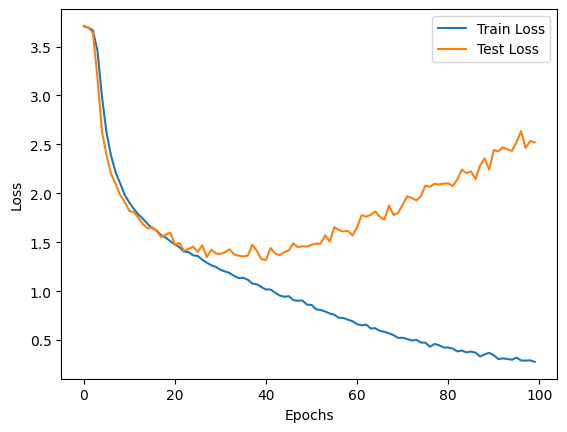

In [21]:
plt.figure()
plt.plot(losses_per_epoch['train'])
plt.plot(losses_per_epoch['val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['Train Loss', 'Test Loss'])
plt.savefig('EEG_Encoding_loss.png')
plt.show()

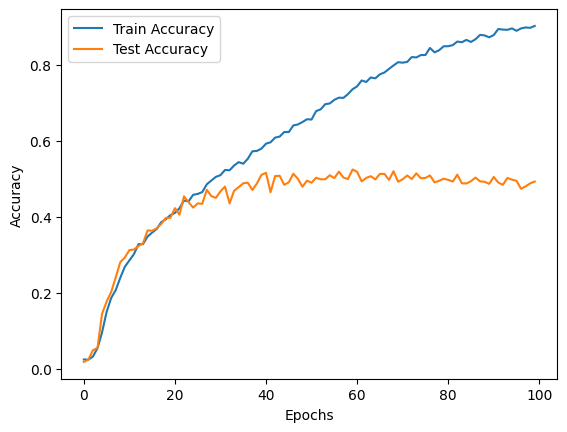

In [22]:
plt.figure()
plt.plot(accuracies_per_epoch['train'])
plt.plot(accuracies_per_epoch['val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.savefig('EEG_Encoding_Accuracy.png')
plt.show()

In [4]:
model = torch.load('/users/sbr/code/Image/EEGChannelNet__subject0_epoch_40.pth').to('cpu')

loaders = {split: DataLoader(Splitter(EEG_Image_Dataset(opt.eeg_dataset, image_path, split), split_path = opt.splits_path, split_num = opt.split_num, split_name = split), batch_size = opt.batch_size, drop_last = True, shuffle = True) for split in ["train", "val", "test"]}

In [9]:
label_list = [
    "sorrel",
    "parachute",
    "iron",
    "anemone fish",
    "espresso maker",
    "coffee mug",
    "mountain bike",
    "revolver",
    "giant panda",
    "daisy",
    "canoe",
    "lycaenid",
    "German shepherd",
    "running shoe",
    "jack-o'-lantern",
    "cellular telephone",
    "golf ball",
    "desktop computer",
    "broom",
    "pizza",
    "missile",
    "capuchin",
    "pool table",
    "mailbag",
    "convertible",
    "folding chair",
    "pajama",
    "mitten",
    "electric guitar",
    "reflex camera",
    "grand piano",
    "mountain tent",
    "banana",
    "bolete",
    "digital watch",
    "African elephant",
    "airliner",
    "electric locomotive",
    "radio telescope",
    "Egyptian cat"
]


/home/sbr/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbr/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


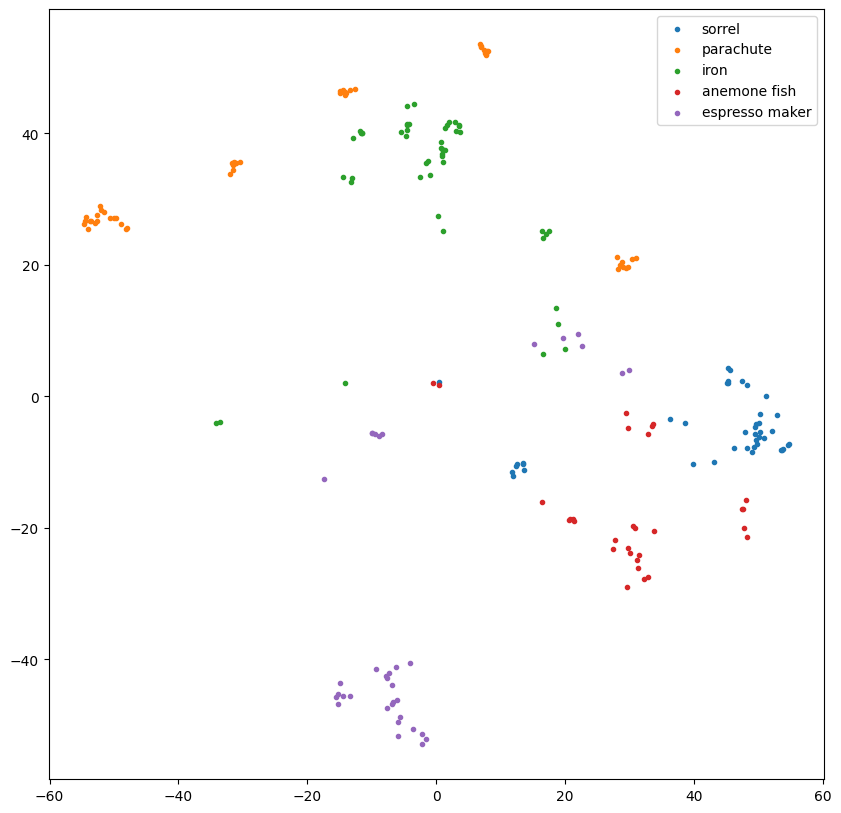

In [31]:
actual = []
deep_features = []
device = 'cuda'
model.to(device)
model.eval() 

with torch.no_grad():
    for data in loaders['test']:
        eeg, labels= data[0].to(device), data[2].to(device)
        features, _ = model(eeg)
        
        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(10, 10))

for i, label in zip(range(5), label_list):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.savefig('Sample t-sne test')
plt.show()

/home/sbr/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbr/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


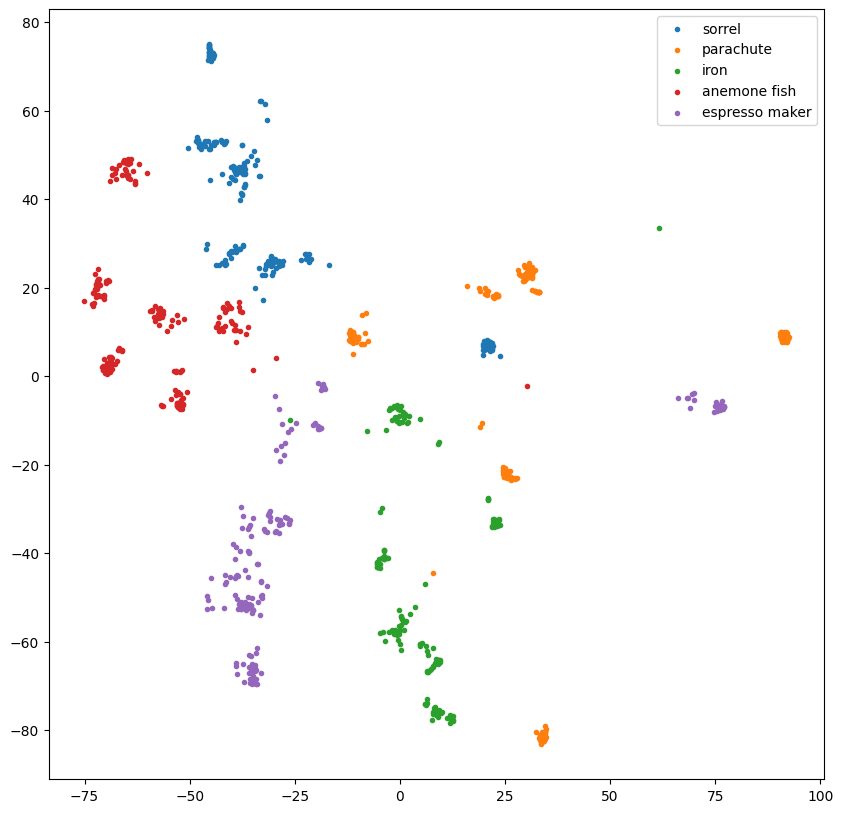

In [32]:
actual = []
deep_features = []
device = 'cuda'
model.to(device)
model.eval() 

with torch.no_grad():
    for data in loaders['train']:
        eeg, labels = data[0].to(device), data[2].to(device)
        features, _ = model(eeg)
        
        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(10, 10))

for i, label in zip(range(5), label_list):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.savefig('Sample t-sne train')
plt.show()

/home/sbr/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbr/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


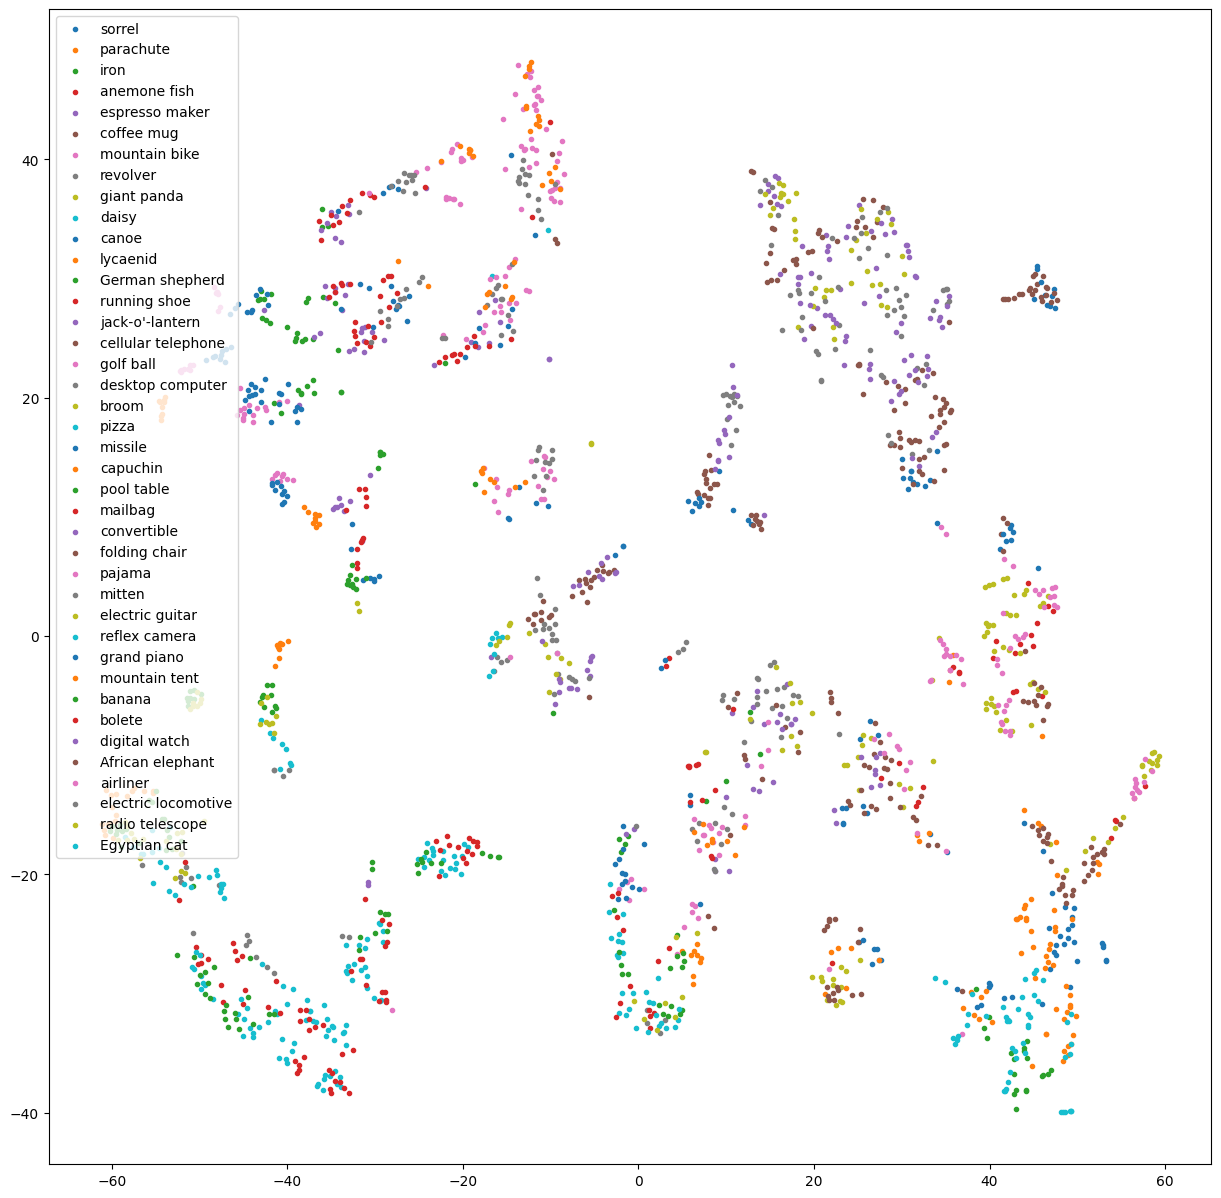

In [33]:
actual = []
deep_features = []
device = 'cuda'
model.to(device)
model.eval() 

with torch.no_grad():
    for data in loaders['test']:
        eeg, labels= data[0].to(device), data[2].to(device)
        features, _ = model(eeg)
        
        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(15, 15))

for i, label in zip(range(40), label_list):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.savefig('All t-sne test')
plt.show()

/home/sbr/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbr/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


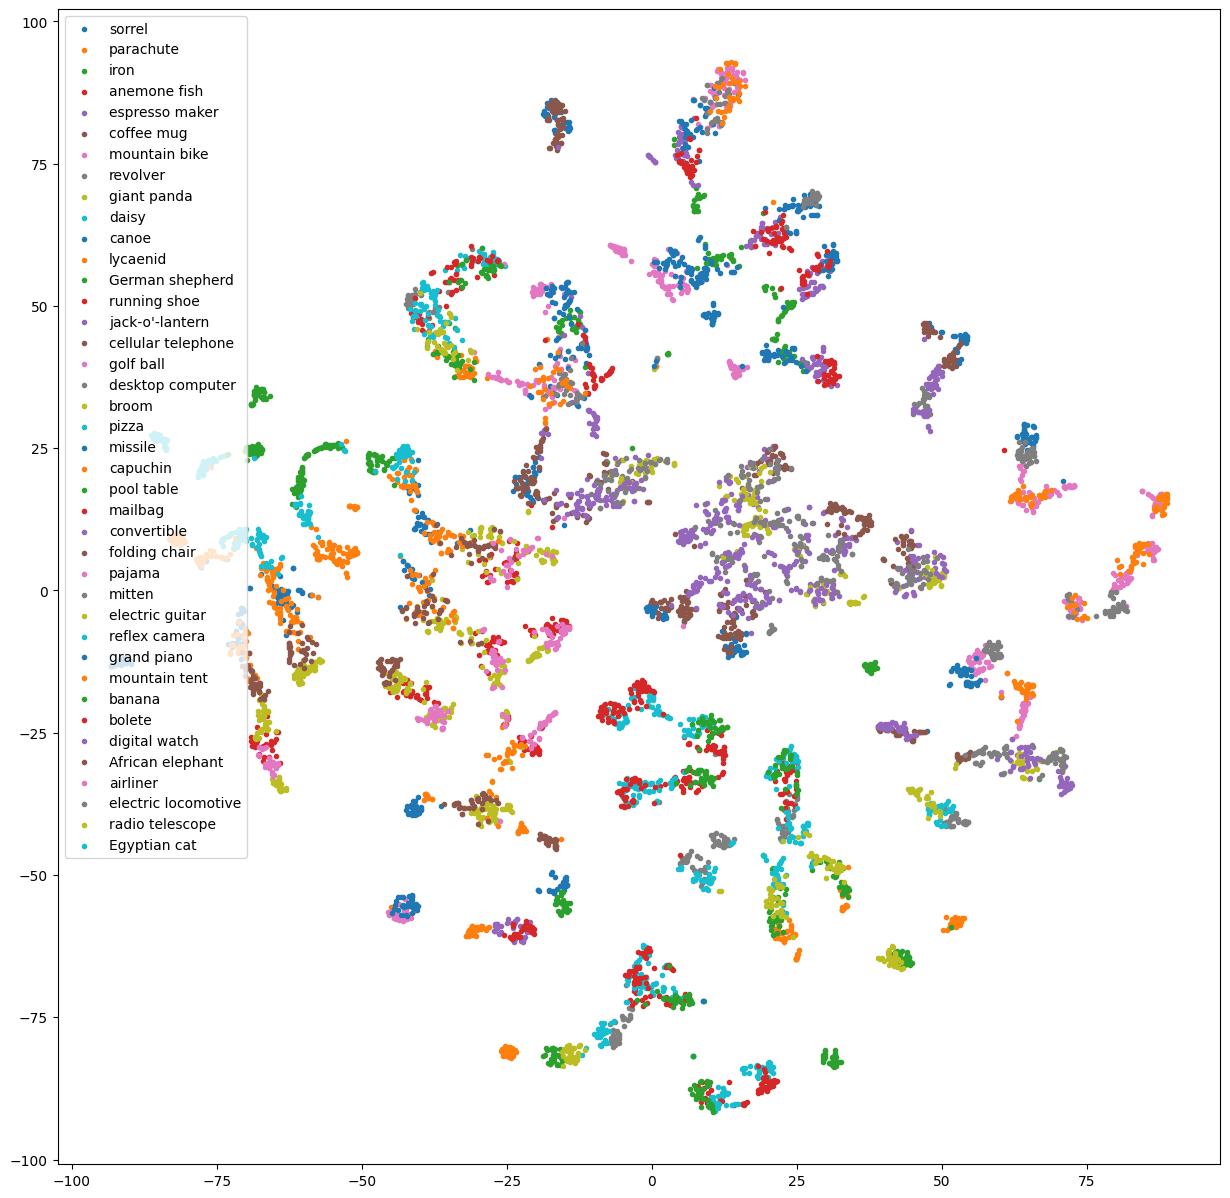

In [35]:
actual = []
deep_features = []
device = 'cuda'
model.to(device)
model.eval() 

with torch.no_grad():
    for data in loaders['train']:
        eeg, labels= data[0].to(device), data[2].to(device)
        features, _ = model(eeg)
        
        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(15, 15))

for i, label in zip(range(40), label_list):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.savefig('All t-sne train')
plt.show()